# Non-Linear Modelling

## Wage dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [3]:
wage = pd.read_csv('./data/Wage.csv')
wage = wage.drop(wage.columns[0], axis=1)

wage['education'] = wage['education'].map({'1. < HS Grad': 1.0, 
                                                 '2. HS Grad': 2.0, 
                                                 '3. Some College': 3.0,
                                                 '4. College Grad': 4.0,
                                                 '5. Advanced Degree': 5.0
                                                })

wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1.0,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3.0,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2.0,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


## 7.8.1 Polynomial regression

In [4]:
degree = 4
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = patsy.dmatrix(f, wage)
y = np.asarray(wage['wage'])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           2.77e-57
Time:                        18:18:33   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.002    -301.879     -66.430
x1            21.2455      5.887      3.609      0.000       9.703      32.788
x2            -0.5639      0.206     -2.736      0.006      -0.968      -0.160
x3             0.0068      0.003      2.221      0.026       0.001       0.013
x4         -3.204e-05   1.64e-05     -1.952      0.051   -6.42e-05    1.45e-07
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                     5.67e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1]:
from sklearn.metrics import mean_squared_error

In [5]:
def confidence_interval(X, model):
    y_hat = model.fittedvalues
    mse = mean_squared_error(y_hat - y)
    cov = mse * np.linalg.inv(X.T @ X)
    var_f = np.diagonal((X @ cov) @ X.T)
    se       = np.sqrt(var_f)
    conf_int = 2*se
    return conf_int

def polyniminal_plot(model, data, x='age', y='wage'):
    conf_int = confidence_interval(X, model)
    y_hat = model.fittedvalues
    fig, ax = plt.subplots(figsize=(10,10))

    sns.scatterplot(x=x, y=y,
                    color='tab:gray',
                    alpha=0.2,
                    ax=ax,
                    data=data)

    sns.lineplot(x=data[x], y=y_hat, ax=ax, color='r')
    sns.lineplot(x=data[x], y=y_hat+conf_int, color='b')
    sns.lineplot(x=data[x], y=y_hat-conf_int, color='b')

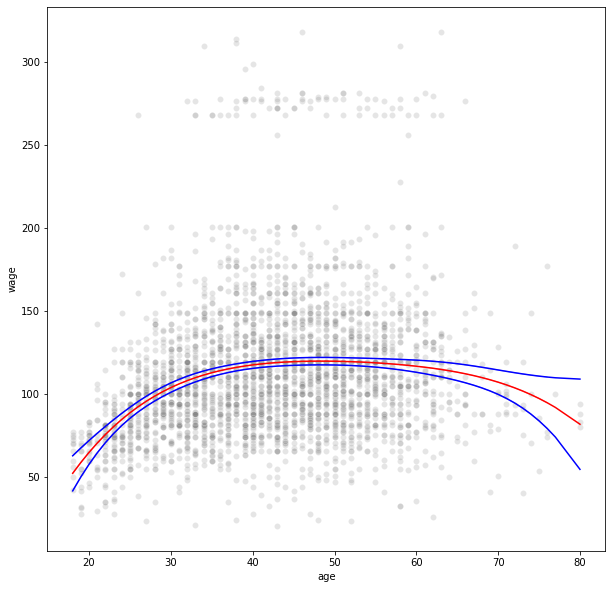

In [6]:
polyniminal_plot(model, wage)

### Selecting degrees of freedom for polynomial regression with ANOVA

**ISL Authors:** In performing a polynomial regression we must decide on the degree of the polynomial to use. One way to do this is by using hypothesis tests. We now fit models ranging from linear to a degree-5 polynomial and seek to determine the simplest model which is sufficient to explain the relationship between wage and age.

In [7]:
degree = 5
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = patsy.dmatrix(f, wage)
y = np.asarray(wage['wage'])

models = []

for i in range(1, degree+1):
    model = sm.OLS(y, X[:, 0:i+1]).fit()
    models += [model]

display(sm.stats.anova_lm(models[0], models[1], models[2], models[3], models[4]))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


**ISL Authors:** The p-value comparing the linear Model 1 to the quadratic Model 2 is essentially zero (<10−15), indicating that a linear fit is not sufficient. Sim- ilarly the p-value comparing the quadratic Model 2 to the cubic Model 3 is very low (0.0017), so the quadratic fit is also insufficient. The p-value comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is ap- proximately 5 % while the degree-5 polynomial Model 5 seems unnecessary because its p-value is 0.37. Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

In [8]:
models[-1].pvalues

array([0.75818559, 0.84262114, 0.77341959, 0.56366932, 0.4460959 ,
       0.36968197])

**Revision note:** ISL suggests that the above results should be same as for annova pvalues, but that isn;t observed here us statsmodels. Why?


**ISL Authors:** However, the ANOVA method works whether or not we used orthogonal polynomials; it also works when we have other terms in the model as well. For example, we can use anova() to compare these three models:

In [9]:
degree = 3
f = 'education +' + ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = patsy.dmatrix(f, wage)
y = np.asarray(wage['wage'])

models = []

for i in range(1, degree+1):
    model = sm.OLS(y, X[:, 0:i+1]).fit()
    models += [model]

# Compare models with ANOVA
display(sm.stats.anova_lm(models[0], models[1], models[2]))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,4.040005e+06,0.0,NaN,NaN,NaN
1,2997.0,3.902335e+06,1.0,137670.252849,109.712226,3.074043e-25
2,2996.0,3.759472e+06,1.0,142862.701185,113.850194,4.111586e-26


### Polynomial logistic regression with bootstrapped confidence intervals

In [10]:
wage['wage_above_250'] = (wage['wage'] > 250).astype(np.float64)
wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage,wage_above_250
0,2006,18,1. Never Married,1. White,1.0,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154,0.0
1,2004,24,1. Never Married,1. White,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020,0.0
2,2003,45,2. Married,1. White,3.0,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177,0.0
3,2003,43,2. Married,3. Asian,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293,0.0
4,2005,50,4. Divorced,1. White,2.0,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154,0.0


In [11]:
degree = 4
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = patsy.dmatrix(f, wage)
y = np.asarray(wage['wage_above_250'])
# Some test observations 
x1 = np.arange(20,81)
X_test  = np.array([np.ones(len(x1)), x1, np.power(x1, 2), np.power(x1, 3), np.power(x1, 4)]).T

model = sm.Logit(y, X).fit(disp=0)
y_hat = model.predict(X_test)

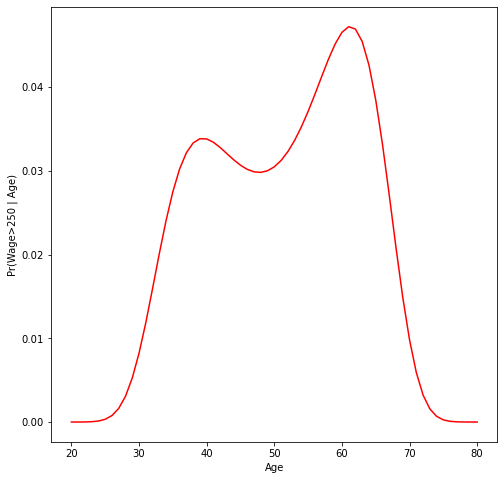

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
plot_df = pd.DataFrame({'Age': x1, 'Pr(Wage>250 | Age)': y_hat})
sns.lineplot(x='Age', y='Pr(Wage>250 | Age)', data=plot_df, color='red')

Here I've used the bootstrap sampling method to get estimates of f(x) for 1000 samples of the dataset. The 5th and 95th percentile of these estimates are shown in blue. The estimate for f(x) using the full dataset is shown in red. 

**Revision note:** I expected the 5th and 95th percentiles to correspond to the confidence intervals reported by the ISL authors. They are largely similar except for the higher bound for high values of age which tends to zero here but for the ISL authors tends to 1.

### Step function

In [13]:
steps = 6
cuts = pd.cut(wage['age'], steps)
X = np.asarray(pd.get_dummies(cuts))
y = np.asarray(wage['wage'])

model = sm.OLS(y, X).fit(disp=0)
y_hat = model.predict(X)

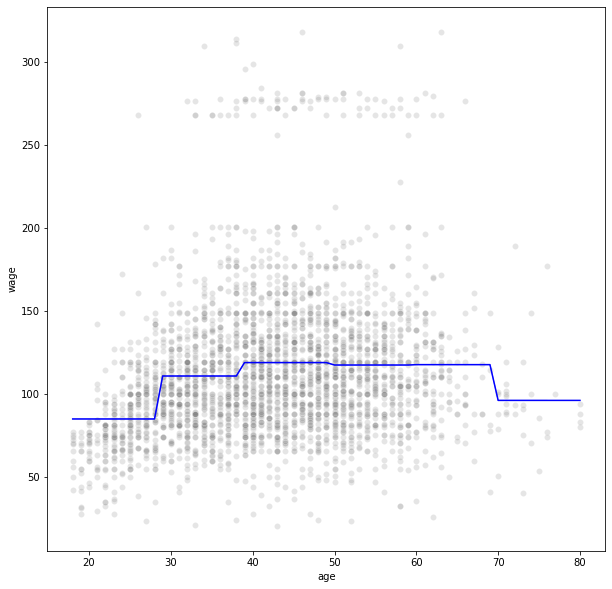

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=wage)

sns.lineplot(x=wage['age'], y=y_hat, ax=ax, color='blue')

sns.rugplot(a=y_hat, ax=ax)

## 7.8.2 Splines


### Basic Spline

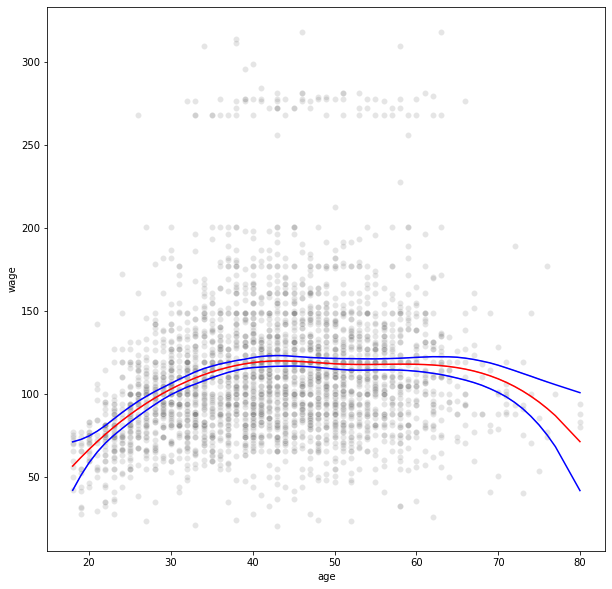

In [15]:
# Fit spline with 6 degrees of freedom
X = patsy.dmatrix('bs(age, df=7, degree=3, include_intercept=True)', wage)
y = np.asarray(wage['wage'])
model = sm.OLS(y, X).fit(disp=0)

polyniminal_plot(model, wage)

### Natural Spline

Natural and cyclic cubic regression splines are provided through the stateful transforms `cr()` and `cc()` respectively. 

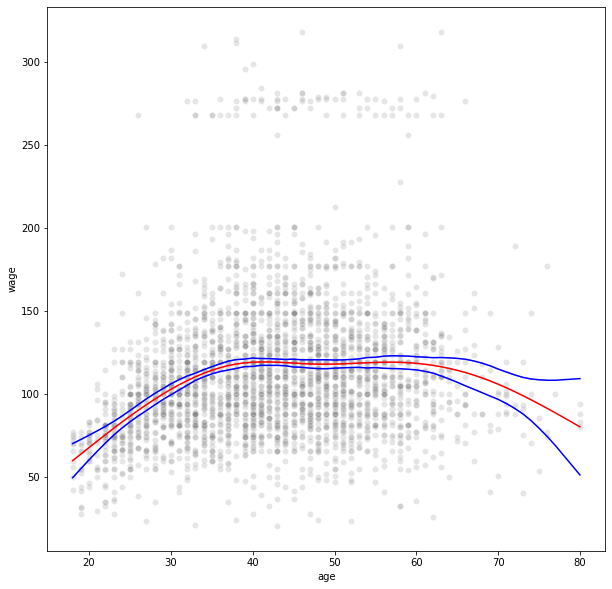

In [16]:
X = patsy.dmatrix('cr(age, df=7)', wage)
y = np.asarray(wage['wage'])
model = sm.OLS(y, X).fit(disp=0)

polyniminal_plot(model, wage)

Comparing the above two plots we can see the increased linearity of the natural spline at the boundaries of age. This seems to yield a slight increase in confidence at the extremes of age.

The ISLR authors cover smoothing splines in addition to the above. Smoothing splines seem to be poorly supported in python, I could only find `scipy.interpolate.UnivariateSpline`.



## 7.8.3 GAMs

**ISL Authors:** We now fit a GAM to predict wage using natural spline functions of year and age, treating education as a qualitative predictor, as in (7.16). Since this is just a big linear regression model using an appropriate choice of basis functions, we can simply do this using the lm() function.

In [17]:
X = patsy.dmatrix('cr(year, df=4)+cr(age, df=5) + education', wage)
y = np.asarray(wage['wage'])
model = sm.OLS(y, X).fit(disp=0)

In [18]:
def gam_plot(x1, x2, x3, data, model, figsize=(8,12)):
    fig, axes = plt.subplots(3,1, sharey=True, figsize=figsize)
    sns.lineplot(x=data[x1], y=model.fittedvalues, ax=axes[0])
    sns.lineplot(x=data[x2], y=model.fittedvalues, ax=axes[1])
    sns.boxplot(x=data[x3], y=model.fittedvalues, ax=axes[2])

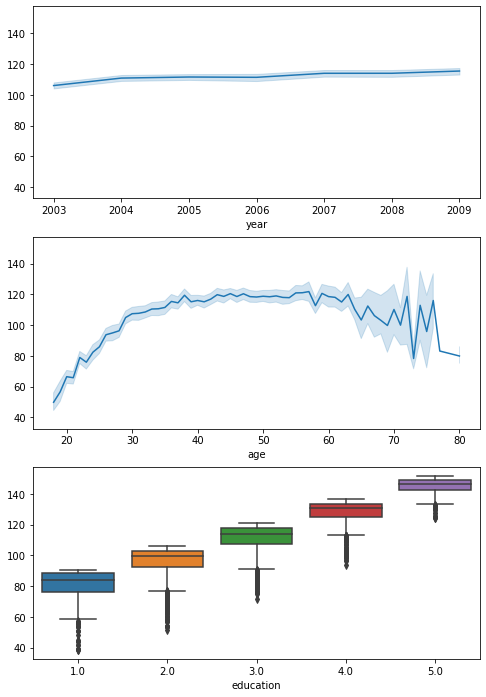

In [19]:
gam_plot('year', 'age', 'education', wage, model, figsize=(8,12))

Not quite the same as plots achived by ISL authors using R, but gives similar insight.

### GAM configurations with ANOVA

In [20]:
# Model 1
X = patsy.dmatrix('cr(age, df=5) + education', wage)
y = np.asarray(wage['wage'])
model1 = sm.OLS(y, X).fit(disp=0)
# Model 2
X = patsy.dmatrix('year+cr(age, df=5) + education', wage)
model2 = sm.OLS(y, X).fit(disp=0)
# Model 3
X = patsy.dmatrix('cr(year, df=4)+cr(age, df=5) + education', wage)
model3 = sm.OLS(y, X).fit(disp=0)

display(sm.stats.anova_lm(model1, model2, model3))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2994.0,3.750437e+06,0.0,NaN,NaN,NaN
1,2993.0,3.732809e+06,1.0,17627.473318,14.129318,0.000174
2,2991.0,3.731516e+06,2.0,1293.696286,0.518482,0.595477


The `Pr(>F)` of 0.000174 for `Model 2` suggests that it is significantly better than model 1 whereas with a pvalue > 0.05 model 3 does not seem to be significantly better than model 2.  

We condlude that inclusion of a linear year feature improves the model, but there is no evidence that a non-linear function of year improves the model.

In [21]:
display(model3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     149.3
Date:                Fri, 06 Mar 2020   Prob (F-statistic):          6.85e-212
Time:                        18:19:18   Log-Likelihood:                -14946.
No. Observations:                3000   AIC:                         2.991e+04
Df Residuals:                    2991   BIC:                         2.996e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.3493      1.799     21.317      0.000      34.822      41.877
x1             5.1741      1.366      3.788      0.000       2.496       7.853
x2             9.3791      1.242      7.550      0.000       6.943      11.815
x3            11.1966      1.294      8.654      0.000       8.660      13.733
x4            12.5995      1.519      8.292      0.000       9.620      15.579
x5           -22.7665      3.283     -6.935      0.000     -29.203     -16.330
x6            15.6588      2.343      6.684      0.000      11.066      20.252
x7            24.5870      1.987     12.372      0.000      20.690      28.484
x8            19.8888      2.546      7.810      0.000      14.896      24.882
x9             0.9812      7.953      0.123      0.902     -14.613      16.576
x10           15.2726      0.536     28.479      0.000      14.221      16.324
==============================================================================
Omnibus:                     1061.067   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5669.217
Skew:                           1.594   Prob(JB):                         0.00
Kurtosis:                       8.933   Cond. No.                     5.74e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.09e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

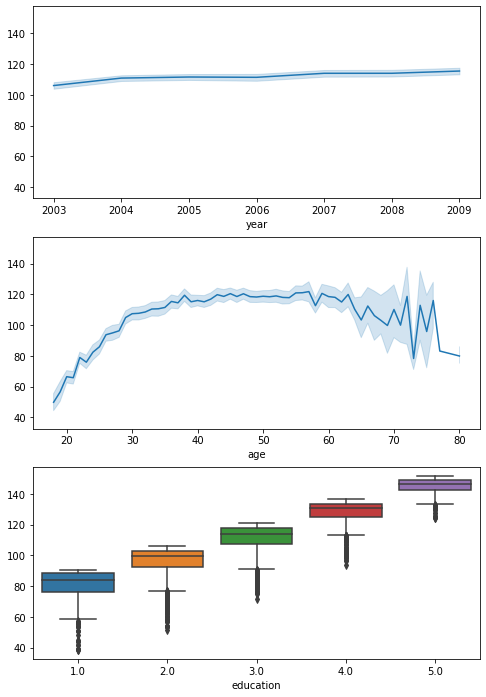

In [22]:
gam_plot('year', 'age', 'education', wage, model3)

Inspecting the pvalues for model 3 features we note a pvalue >0.05 for x9 which correspondes to the 5th degree of freedom for age. 

**Revision note:** The ISL authors report high pvalues for year features, which would reinforce the above ANOVA result, but we can't see that here. Perhaps the OLS `.summary()` is not equivalent to R's `summary(gam)`

### Local Regression GAM

In [23]:
x = np.asarray(wage['age'])
y = np.asarray(wage['wage'])

# local regression with span=0.7
wage['age_lowess'] = sm.nonparametric.lowess(y, x, frac=.7, return_sorted=False)

X = patsy.dmatrix('cr(year, df=4)+ age_lowess + education', wage)
y = np.asarray(wage['wage'])
model_gam = sm.OLS(y, X).fit(disp=0)
model_gam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     239.0
Date:                Fri, 06 Mar 2020   Prob (F-statistic):          2.74e-215
Time:                        18:19:23   Log-Likelihood:                -14946.
No. Observations:                3000   AIC:                         2.990e+04
Df Residuals:                    2994   BIC:                         2.994e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.2295      5.977     -6.396      0.000     -49.949     -26.510
x1           -14.0090      1.973     -7.102      0.000     -17.877     -10.141
x2            -9.7151      1.886     -5.151      0.000     -13.413      -6.017
x3            -7.9607      1.917     -4.153      0.000     -11.719      -4.202
x4            -6.5447      2.091     -3.129      0.002     -10.645      -2.444
x5             1.0823      0.071     15.208      0.000       0.943       1.222
x6            15.3535      0.534     28.746      0.000      14.306      16.401
==============================================================================
Omnibus:                     1056.253   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5640.862
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                       8.922   Cond. No.                     4.86e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.41e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

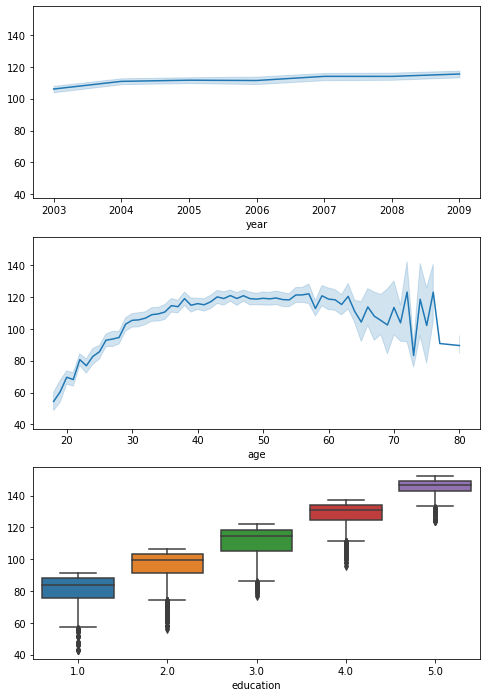

In [24]:
gam_plot('year', 'age', 'education', wage, model_gam)

In [25]:
age = np.asarray(wage['age'])
year = np.asarray(wage['year'])
wage_ = np.asarray(wage['wage'])

# local regression with span=0.7
wage['age_lowess'] = sm.nonparametric.lowess(wage_, age, frac=.5, return_sorted=False)
wage['year_lowess'] = sm.nonparametric.lowess(wage_, year, frac=.5, return_sorted=False)

X = patsy.dmatrix('year_lowess:age_lowess + education', wage)
y = np.asarray(wage['wage_above_250'])
model_gam2 = sm.OLS(y, X).fit(disp=0)
model_gam2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     55.21
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           2.85e-24
Time:                        18:19:30   Log-Likelihood:                 1292.9
No. Observations:                3000   AIC:                            -2580.
Df Residuals:                    2997   BIC:                            -2562.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.030     -4.183      0.000      -0.185      -0.067
x1          7.453e-06   2.71e-06      2.753      0.006    2.15e-06    1.28e-05
x2             0.0232      0.002      9.722      0.000       0.018       0.028
==============================================================================
Omnibus:                     3190.115   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           132683.181
Skew:                           5.594   Prob(JB):                         0.00
Kurtosis:                      33.599   Cond. No.                     1.17e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

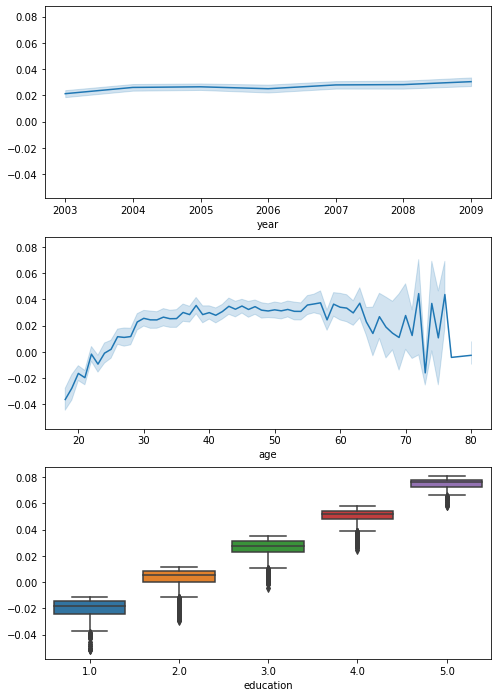

In [26]:
gam_plot('year', 'age', 'education', wage, model_gam2)

In [27]:
X = patsy.dmatrix('year + cr(age, df=5) + education', wage)
y = np.asarray(wage['wage_above_250'])
model_gam3 = sm.Logit(y, X).fit(disp=0)

In [28]:
pd.pivot_table(wage, values=['wage_above_250'],\
               index='education', aggfunc=['sum', 'count'])

,sum,count
,wage_above_250,wage_above_250
education,,
1.0,0.0,268
2.0,5.0,971
3.0,7.0,650
4.0,22.0,685
5.0,45.0,426


In [29]:
wage_sub = wage[wage['education']!=1]

X = patsy.dmatrix('year + cr(age, df=5) + education', wage_sub)
y = np.asarray(wage_sub['wage_above_250'])
model_gam4 = sm.Logit(y, X).fit(disp=0)
model_gam4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2732
Model:                          Logit   Df Residuals:                     2725
Method:                           MLE   Df Model:                            6
Date:                Fri, 06 Mar 2020   Pseudo R-squ.:                  0.1567
Time:                        18:19:38   Log-Likelihood:                -301.70
converged:                       True   LL-Null:                       -357.77
Covariance Type:            nonrobust   LLR p-value:                 7.244e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -47.2564        nan        nan        nan         nan         nan
x1             0.0234      0.058      0.405      0.686      -0.090       0.137
x2           -14.9236        nan        nan        nan         nan         nan
x3            -7.5040        nan        nan        nan         nan         nan
x4            -7.0826        nan        nan        nan         nan         nan
x5            -6.7605        nan        nan        nan         nan         nan
x6           -10.9854        nan        nan        nan         nan         nan
x7             1.0505      0.135      7.778      0.000       0.786       1.315
==============================================================================
"""

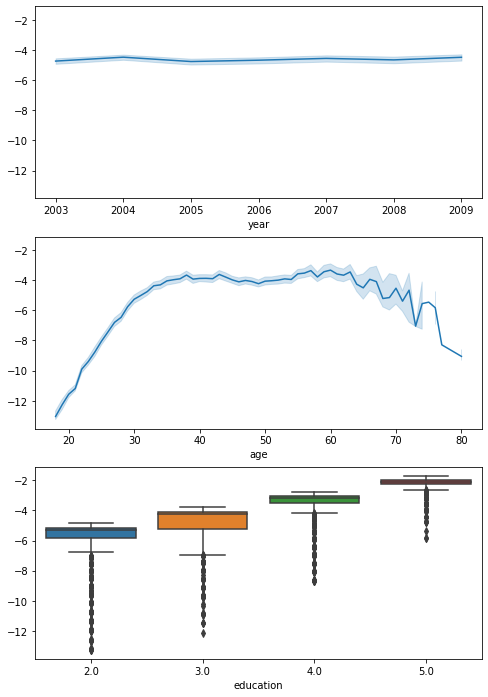

In [30]:
gam_plot('year', 'age', 'education', wage_sub, model_gam4)